In [1]:
import pandas as pd
import rasterio
from matplotlib import pyplot as plt

In [2]:
google_scenes = pd.read_csv('landsat8_scenes.csv.gz', compression='gzip')

In [3]:
google_scenes.head()

Unnamed: 0               SCENE_ID  \
0          13  LC80420242021050LGN00   
1          84  LC80350312021097LGN00   
2         131  LC80160322020266LGN00   
3         142  LC80990192021082LGN00   
4         151  LC81500232021279LGN00   

                                 PRODUCT_ID SPACECRAFT_ID SENSOR_ID  \
0  LC08_L1TP_042024_20210219_20210304_01_T1     LANDSAT_8  OLI_TIRS   
1  LC08_L1TP_035031_20210407_20210416_01_T1     LANDSAT_8  OLI_TIRS   
2  LC08_L1TP_016032_20200922_20201006_01_T1     LANDSAT_8  OLI_TIRS   
3  LC08_L1TP_099019_20210323_20210401_01_T1     LANDSAT_8  OLI_TIRS   
4  LC08_L1TP_150023_20211006_20211013_01_T1     LANDSAT_8  OLI_TIRS   

  DATE_ACQUIRED  COLLECTION_NUMBER COLLECTION_CATEGORY  \
0    2021-02-19                  1                  T1   
1    2021-04-07                  1                  T1   
2    2020-09-22                  1                  T1   
3    2021-03-23                  1                  T1   
4    2021-10-06                  1                  T1   

                   SENSING_TIME DATA_TYPE  WRS_PATH  WRS_ROW  CLOUD_COVER  \
0  2021-02-19T18:29:47.4169550Z      L1TP        42       24        29.01   
1  2021-04-07T17:49:00.1397309Z      L1TP        35       31        60.04   
2  2020-09-22T15:52:30.8548679Z      L1TP        16       32         0.01   
3  2021-03-23T00:19:49.8277559Z      L1TP        99       19        71.52   
4  2021-10-06T05:37:11.5889239Z      L1TP       150       23        93.91   

   NORTH_LAT  SOUTH_LAT   WEST_LON   EAST_LON  TOTAL_SIZE  \
0   52.82383   50.53215 -115.75399 -112.10110  1055732093   
1   42.84670   40.64567 -108.35909 -105.45684  1175533201   
2   41.43970   39.20399  -79.43177  -76.54648   997635437   
3   59.80589   57.56482  159.65508  163.92157   945040241   
4   54.19447   51.97587   78.03776   81.72345   916189949   

                                            BASE_URL  
0  gs://gcp-public-data-landsat/LC08/01/042/024/L...  
1  gs://gcp-public-data-landsat/LC08/01/035/031/L...  
2  gs://gcp-public-data-landsat/LC08/01/016/032/L...  
3  gs://gcp-public-data-landsat/LC08/01/099/019/L...  
4  gs://gcp-public-data-landsat/LC08/01/150/023/L...

In [4]:
def wysz_sce_landsat (path, row, data_od, data_do, satelita, limit_zachmurzenia):
    scenes = google_scenes[(google_scenes.WRS_PATH == path) & (google_scenes.WRS_ROW == row) &
                    (google_scenes.DATE_ACQUIRED >= data_od) &
                    (google_scenes.DATE_ACQUIRED <= data_do) &
                    (google_scenes.CLOUD_COVER <= limit_zachmurzenia) & 
                    (google_scenes.SPACECRAFT_ID==satelita) &
                    (~google_scenes.PRODUCT_ID.str.contains('_T2')) &
                    (~google_scenes.PRODUCT_ID.str.contains('_RT'))]
    best_scene = scenes.sort_values('CLOUD_COVER').iloc[0]
    best_scene
    return best_scene

In [5]:
def wczytaj_obraz(scena, band):
    url = scena.BASE_URL
    url = url[5:]
    url = url + "/" + url[-40:] + "_" + band + ".TIF"
    url = 'https://storage.googleapis.com/' +url
    print(url)
    with rasterio.open(url) as src:
        landsat = src.read(1)
    return landsat

In [6]:
best_scene = wysz_sce_landsat(path=189, row = 25, data_od = "2020-01-01", data_do = "2022-06-01", satelita = "LANDSAT_8",limit_zachmurzenia = 10)

band4 = wczytaj_obraz(scena=best_scene,band='B4')
band5 = wczytaj_obraz(scena=best_scene,band='B5')

https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/189/025/LC08_L1TP_189025_20200411_20200422_01_T1/LC08_L1TP_189025_20200411_20200422_01_T1_B4.TIF
https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/189/025/LC08_L1TP_189025_20200411_20200422_01_T1/LC08_L1TP_189025_20200411_20200422_01_T1_B5.TIF


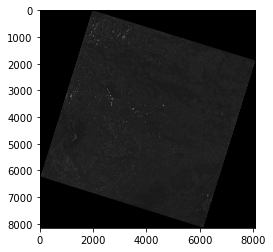

In [7]:
plt.imshow(band4,cmap='gray')

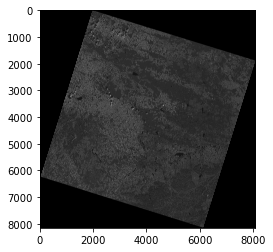

In [8]:
plt.imshow(band5,cmap='gray')

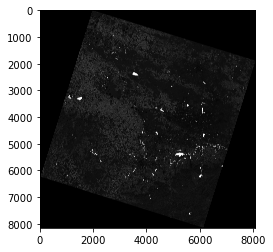

In [9]:
rozn = band5-band4
plt.imshow(rozn,cmap='gray')

In [10]:
def licz_ndvi_l8(b4,b5):
    b4 = b4.astype('float64')
    b5 = b5.astype('float64')

    b4[b4 == 0] = 'nan'
    b5[b5 == 0] = 'nan'

    ndvi = (b5-b4)/(b5+b4)
    return ndvi

In [13]:
ndvi_karpaty = licz_ndvi_l8(band4,band5)

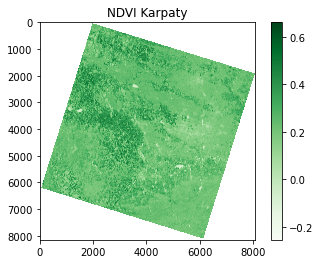

In [14]:
plt.imshow(ndvi_karpaty,cmap='Greens')
plt.colorbar()
plt.title('NDVI Karpaty')
plt.savefig('ndvi.png',dpi=300)